In [1]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import cv2
from glob import glob
from vgg import vgg_16

slim = tf.contrib.slim

In [2]:
tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32, shape=(1,224,224,3), name='input')
net, endpoints = vgg_16(x, 1000, is_training=False)
conv_layer5_3 = endpoints['vgg_16/conv5/conv5_3']
fc_8 = endpoints['vgg_16/fc8']

The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1.
This signal is then backpropagated to the rectified convolutional feature maps of interest, which we combine to compute the coarse Grad-CAM localization (blue heatmap) which represents where the model has to look to make the particular decision.

In [3]:
prediction = tf.argmax(fc_8, axis=1)
one_hot = tf.sparse_to_dense(prediction, [1000], 1.0)
signal = tf.multiply(fc_8, one_hot)
loss = tf.reduce_mean(signal)

grads = tf.gradients(loss, conv_layer5_3)[0]
norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

In [4]:
model_path = 'vgg_16.ckpt'
image_dir = 'CAM_testimage/'
image_list = glob(image_dir + '*')

INFO:tensorflow:Restoring parameters from vgg_16.ckpt


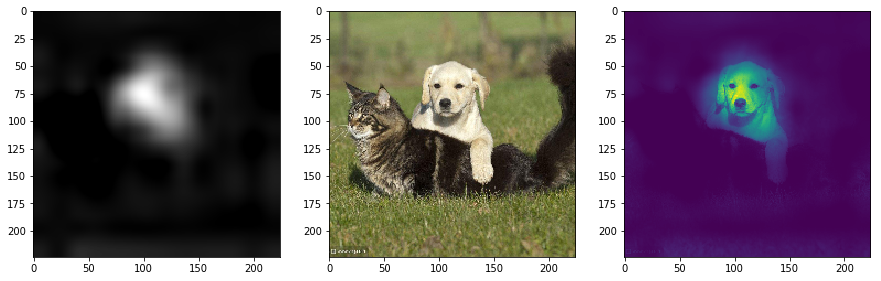

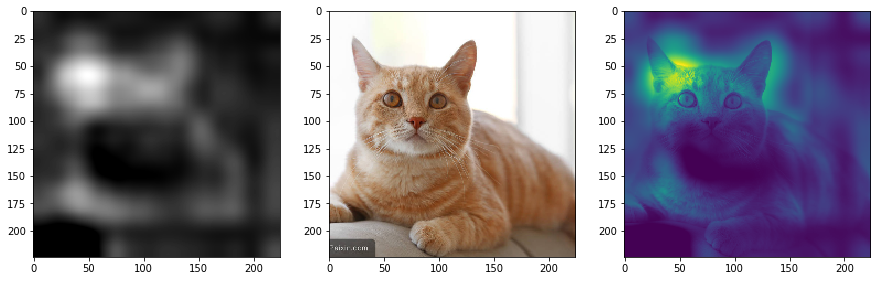

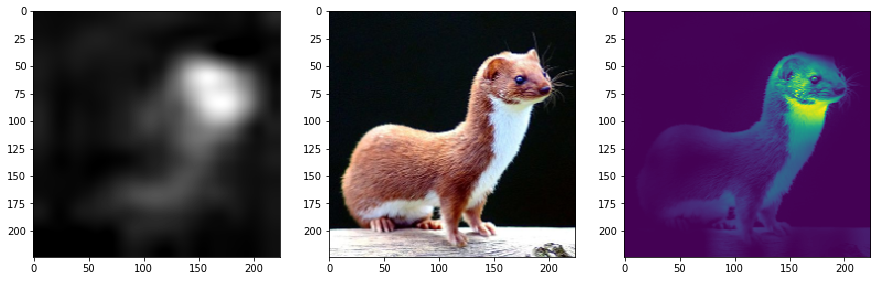

In [5]:
with tf.Session() as sess:
    tf.global_variables_initializer()
    variables = slim.get_variables_to_restore()
    var_dict = {}
    for v,s in tf.contrib.framework.list_variables(model_path):
        var_dict[v] = s
    var_restore = []
    for v in variables:
        if v.name[:-2] in var_dict:
            if v.shape == var_dict[v.name[:-2]]:
                var_restore.append(v)
    saver = tf.train.Saver(var_restore)
    saver.restore(sess, model_path)
    
    for image_path in image_list:
        img = cv2.imread(image_path)
        img = cv2.resize(img, (224,224))
        img = np.reshape(img, (1,224,224,3))
        
        output, grads_val, p = sess.run([conv_layer5_3, norm_grads, prediction], feed_dict = {x:img})

        output = np.squeeze(output)
        grads_val = np.squeeze(grads_val)

        weights = np.mean(grads_val, axis = (0, 1))
        cam = np.ones(img.shape[1 : 3], dtype = np.float32)

        # Taking a weighted average
        for i, w in enumerate(weights):
            cam += w * cv2.resize(output[:, :, i], (224,224), interpolation = cv2.INTER_CUBIC)

        # Passing through ReLU
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)
        
        i = np.squeeze(img)
        i_gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        i[:,:,[0,2]] = i[:,:,[2,0]]
        result = np.multiply(i_gray, cam)
        fig = plt.figure(figsize=(15,15))
        plt.subplot(131)
        plt.imshow(cam, cmap='gray')
        plt.subplot(132)
        plt.imshow(i)
        plt.subplot(133)
        plt.imshow(result)